# ChromaDB


In [5]:
!pip install chromadb

In [6]:
!pip install langchain

In [7]:
!pip install -U langchain-community

In [8]:
pip install chroma-migrate

Note: you may need to restart the kernel to use updated packages.


In [9]:
from chromadb import Client
from chromadb.config import Settings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from chromadb.utils import embedding_functions
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
import json
import time


In [10]:
# Configurar a chave de API da OpenAI
import openai
from dotenv import load_dotenv
import os

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

In [11]:
# # Função para gerar embeddings com a OpenAI
# def get_embedding_function(texts, batch_size=16, model="text-embedding-3-small"):
#     """
#     Retorna uma lista de embeddings gerados pela OpenAI para uma lista de textos.

#     Args:
#         texts (list): Lista de textos para gerar embeddings.
#         batch_size (int): Número de textos processados por lote.
#         model (str): Nome do modelo da OpenAI para embeddings.

#     Returns:
#         list: Lista de embeddings.
#     """
#     result = []

#     # Dividir os textos em lotes para processar
#     for i in range(0, len(texts), batch_size):
#         response = openai.Embedding.create(
#             input=texts[i: i + batch_size],
#             model=model  # Modelo para gerar embeddings
#         )
#         embeddings = [res['embedding'] for res in response['data']]
#         result.extend(embeddings)
    
#     return result

In [12]:
import os
import json
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from chromadb import Client
from chromadb.config import Settings
import openai

from dotenv import load_dotenv

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

# Caminhos
JSON_PATH = r"/home/lisamenezes/RAG-benchmark/data/fundamentos-all.json"
CHROMA_PATH = r"/home/lisamenezes/RAG-benchmark/data/Chroma"

# Função para carregar documentos do JSON
def load_documents_from_json(json_path: str):
    """
    Carrega documentos de um arquivo JSON.
    """
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"O arquivo JSON não foi encontrado: {json_path}")

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    documents = []
    for item in data:
        text = item.get("text", "")
        metadata = {
            "chunk_heading": item.get("chunk_heading", "Unknown Heading"),
        }
        documents.append(Document(page_content=text, metadata=metadata))

    print(f"Carregados {len(documents)} documentos.")
    return documents

# Função para dividir documentos em chunks
def split_documents(documents: list[Document], chunk_size=800, chunk_overlap=80):
    """
    Divide os documentos em chunks para facilitar a indexação.
    """
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        is_separator_regex=False,
    )
    texts = text_splitter.split_documents(documents)
    print(f"Divididos em {len(texts)} chunks.")
    return texts

# Função para gerar embeddings com a OpenAI
def get_embedding_function():
    """
    Retorna uma função que gera embeddings utilizando a OpenAI.
    """
    def embedding_fn(texts):
        result = []
        batch_size = 16
        model="text-embedding-3-small"
        for i in range(0, len(texts), batch_size):
            response = openai.Embedding.create(
                input=texts[i: i + batch_size],
                model=model
            )
            embeddings = [res['embedding'] for res in response['data']]
            result.extend(embeddings)
        return result
    return embedding_fn

# Função para adicionar chunks ao Chroma
def add_to_chroma(chunks: list[Document], chroma_path: str):
    """
    Adiciona os chunks ao banco de dados Chroma e persiste.
    """
    embedding_fn = get_embedding_function()

    # Criar ou carregar o banco de dados Chroma
    client = Client(Settings(persist_directory=chroma_path))
    collection = client.get_or_create_collection(name="document_chunks")

    # Adicionar documentos ao banco de dados
    for i, chunk in enumerate(chunks):
        collection.add(
            documents=[chunk.page_content],
            metadatas=[chunk.metadata],
            ids=[str(i)]
        )

    print(f"Persistência concluída em {chroma_path}.")
    return client

# Carregar os documentos
documents = load_documents_from_json(JSON_PATH)

# Dividir os documentos em chunks
chunks = split_documents(documents)

# Indexar os chunks no Chroma
chroma_db = add_to_chroma(chunks, CHROMA_PATH)

# Exemplo de saída
print(f"Primeiro chunk indexado:\n{chunks[0]}")

Carregados 18499 documentos.
Divididos em 21704 chunks.


/home/lisamenezes/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:11<00:00, 7.28MiB/s]


Persistência concluída em /home/lisamenezes/RAG-benchmark/data/Chroma.
Primeiro chunk indexado:
page_content='Art. 1oToda pessoa é capaz de direitos e deveres na ordem civil.' metadata={'chunk_heading': 'capacidade civil'}


In [13]:
# Gerar IDs únicos para os chunks
last_page_id = None
current_chunk_index = 0

for chunk in chunks:
    source = chunk.metadata.get('chunk_heading', 'Unknown Heading')
    context = chunk.metadata.get('context', 'No Context')  # Ajuste para JSON

    # Usar 'source' ou outro identificador como 'current_page_id'
    current_page_id = source

    # Lógica para rastrear o índice do chunk dentro de uma página
    if current_page_id == last_page_id:
        current_chunk_index += 1
    else:
        current_chunk_index = 0

    # Atualizar o último page_id processado
    last_page_id = current_page_id

    # Criar um ID único para o chunk
    chunk_id = f"{current_page_id}-{current_chunk_index}"

    # Adicionar o ID ao metadado do chunk
    chunk.metadata["id"] = chunk_id

    # Imprimir os resultados
    print(f"Source: {source}, Context: {context}, Chunk Index: {current_chunk_index}, Chunk ID: {chunk_id}")


Source: capacidade civil, Context: No Context, Chunk Index: 0, Chunk ID: capacidade civil-0
Source: direitos e deveres, Context: No Context, Chunk Index: 0, Chunk ID: direitos e deveres-0
Source: sujeito de direito, Context: No Context, Chunk Index: 0, Chunk ID: sujeito de direito-0
Source: nascimento com vida, Context: No Context, Chunk Index: 0, Chunk ID: nascimento com vida-0
Source: direitos do nascituro, Context: No Context, Chunk Index: 0, Chunk ID: direitos do nascituro-0
Source: personalidade civil, Context: No Context, Chunk Index: 0, Chunk ID: personalidade civil-0
Source: menor de 16 anos, Context: No Context, Chunk Index: 0, Chunk ID: menor de 16 anos-0
Source: incapaz civil, Context: No Context, Chunk Index: 0, Chunk ID: incapaz civil-0
Source: incapacidade absoluta, Context: No Context, Chunk Index: 0, Chunk ID: incapacidade absoluta-0
Source: incapacidade relativa, Context: No Context, Chunk Index: 0, Chunk ID: incapacidade relativa-0
Source: menor de idade, Context: No 

In [14]:
# Indexar os chunks no Chroma
chroma_db = add_to_chroma(chunks, CHROMA_PATH)

# Carregar banco existente
db = Client(Settings(persist_directory=CHROMA_PATH))
collection = db.get_collection(name="document_chunks")

# Obter IDs existentes no banco
existing_items = collection.get()
existing_ids = set(existing_items["ids"])

print(f"Número de documentos existentes no banco de dados: {len(existing_ids)}")

# Certifique-se de que cada chunk tenha um ID no metadado
chunks_with_ids = []
for chunk in chunks:
    chunk_id = chunk.metadata["id"]
    chunks_with_ids.append(chunk)

# Filtrar os chunks que ainda não estão no banco de dados
new_chunks = []
for chunk in chunks_with_ids:
    if chunk.metadata["id"] not in existing_ids:
        new_chunks.append(chunk)

print(f"Número de novos chunks para adicionar: {len(new_chunks)}")

# Adicionar novos chunks ao banco de dados, apenas se forem novos
if new_chunks:
    for chunk in new_chunks:
        collection.add(
            documents=[chunk.page_content],
            metadatas=[chunk.metadata],
            ids=[chunk.metadata["id"]]
        )
    print(f"Número de novos chunks adicionados ao banco de dados: {len(new_chunks)}")
else:
    print("Nenhum novo chunk para adicionar.")

# Exemplo de saída
print(f"Primeiro chunk indexado:\n{chunks[0]}")



Insert of existing embedding ID: 0
Add of existing embedding ID: 0
Insert of existing embedding ID: 1
Add of existing embedding ID: 1
Insert of existing embedding ID: 2
Add of existing embedding ID: 2
Insert of existing embedding ID: 3
Add of existing embedding ID: 3
Insert of existing embedding ID: 4
Add of existing embedding ID: 4
Insert of existing embedding ID: 5
Add of existing embedding ID: 5
Insert of existing embedding ID: 6
Add of existing embedding ID: 6
Insert of existing embedding ID: 7
Add of existing embedding ID: 7
Insert of existing embedding ID: 8
Add of existing embedding ID: 8
Insert of existing embedding ID: 9
Add of existing embedding ID: 9
Insert of existing embedding ID: 10
Add of existing embedding ID: 10
Insert of existing embedding ID: 11
Add of existing embedding ID: 11
Insert of existing embedding ID: 12
Add of existing embedding ID: 12
Insert of existing embedding ID: 13
Add of existing embedding ID: 13
Insert of existing embedding ID: 14
Add of existing em

Persistência concluída em /home/lisamenezes/RAG-benchmark/data/Chroma.
Número de documentos existentes no banco de dados: 21704
Número de novos chunks para adicionar: 21704


Insert of existing embedding ID: capacidade civil-0
Add of existing embedding ID: capacidade civil-0
Insert of existing embedding ID: direito à imagem-0
Add of existing embedding ID: direito à imagem-0
Insert of existing embedding ID: privacidade-0
Add of existing embedding ID: privacidade-0
Insert of existing embedding ID: direito à privacidade-0
Add of existing embedding ID: direito à privacidade-0
Insert of existing embedding ID: nomeação de curador-0
Add of existing embedding ID: nomeação de curador-0
Insert of existing embedding ID: ausência do cônjuge-0
Add of existing embedding ID: ausência do cônjuge-0
Insert of existing embedding ID: sucessão provisória-0
Add of existing embedding ID: sucessão provisória-0
Insert of existing embedding ID: sucessão provisória-0
Add of existing embedding ID: sucessão provisória-0
Insert of existing embedding ID: posse provisória-0
Add of existing embedding ID: posse provisória-0
Insert of existing embedding ID: sucessão definitiva-0
Add of exist

Número de novos chunks adicionados ao banco de dados: 21704
Primeiro chunk indexado:
page_content='Art. 1oToda pessoa é capaz de direitos e deveres na ordem civil.' metadata={'chunk_heading': 'capacidade civil', 'id': 'capacidade civil-0'}


In [15]:
db = Client(Settings(persist_directory=CHROMA_PATH))
collection = db.get_collection(name="document_chunks")
print(f"Número de documentos no banco: {len(collection.get()['ids'])}")


Número de documentos no banco: 39540


In [16]:
from hugchat import hugchat
from hugchat.login import Login
import time

# Configurações de login no HuggingFace
EMAIL = "hdsdosol@gmail.com"
PASSWD = "Lisa2210@"
COOKIE_PATH_DIR = "./cookies/"  # Diretório onde os cookies serão salvos

# Login no HuggingFace
sign = Login(EMAIL, PASSWD)
cookies = sign.login(cookie_dir_path=COOKIE_PATH_DIR, save_cookies=True)

# Cria o ChatBot com os cookies obtidos
chatbot = hugchat.ChatBot(cookies=cookies.get_dict())

# Função para chamar o modelo via HuggingChat
def call_huggingchat(prompt, model_name, retries=3, delay=20):
    """
    Realiza a inferência utilizando HuggingChat.

    Args:
        prompt (str): O prompt formatado para o modelo.
        model_name (str): Nome do modelo a ser utilizado.
        retries (int): Número de tentativas para reconexão em caso de erro.
        delay (int): Intervalo de espera entre tentativas (em segundos).

    Returns:
        str: Resposta gerada pelo modelo ou None em caso de erro.
    """
    # Obter a lista de modelos disponíveis
    models = chatbot.get_available_llm_models()
    model_index = next((i for i, m in enumerate(models) if m.id == model_name), None)

    if model_index is not None:
        chatbot.switch_llm(model_index)
        print(f"Modelo '{model_name}' selecionado com sucesso!")
    else:
        raise ValueError(f"Modelo '{model_name}' não encontrado entre os disponíveis.")

    for attempt in range(retries):
        try:
            chatbot.new_conversation(switch_to=True)
            response = chatbot.chat(prompt)
            return response
        except Exception as e:
            print(f"Erro na tentativa {attempt + 1}: {e}")
            if "You are sending too many messages" in str(e):
                time.sleep(delay)
            else:
                break

    return None

# Função para consulta no RAG
def query_rag(query_text: str):
    """
    Realiza uma consulta no banco Chroma utilizando Similaridade e gera uma resposta
    com base no contexto encontrado.

    Args:
        query_text (str): Pergunta que será respondida com base no contexto encontrado.

    Returns:
        str: Resposta gerada pelo modelo com base no contexto.
    """
    PROMPT_TEMPLATE = """
    Responda à pergunta apenas com base no seguinte contexto:
    {context}

    ---

    Responda à pergunta com base no contexto acima: {question}
    """

    # Busca os documentos mais similares com base na consulta
    try:
        results = collection.query(
            query_texts=[query_text],
            n_results=5,  # Retorna os 5 documentos mais similares
        )
    except Exception as e:
        print(f"Erro ao realizar a busca no banco Chroma: {e}")
        return

    # Verifica e constrói o contexto com base nos resultados
    try:
        # Extração do texto do contexto dos resultados retornados
        context_texts = []
        for document, metadata in zip(results["documents"][0], results["metadatas"][0]):
            context_texts.append(f"{document}\n[Metadata: {metadata}]")

        context = "\n\n---\n\n".join(context_texts)
    except (KeyError, IndexError) as e:
        print(f"Erro ao processar os resultados: {e}")
        return

    # Exibir os documentos recuperados
    print("\nDocumentos recuperados do banco Chroma:")
    for doc in context_texts:
        print(doc)

    # Formatar o prompt com a pergunta e o contexto
    prompt = PROMPT_TEMPLATE.format(context=context, question=query_text)

    # Fazer a inferência com HuggingChat
    try:
        response = call_huggingchat(prompt, model_name="meta-llama/Meta-Llama-3.1-70B-Instruct")
    except Exception as e:
        print(f"Erro ao gerar a resposta com o modelo HuggingChat: {e}")
        return

    return response

# Exemplo de uso da função
query = "Qual é a definição de capacidade civil?"
response = query_rag(query)

# Exibir a resposta
if response:
    print("\nResposta gerada pelo modelo HuggingChat:")
    print(response)


Documentos recuperados do banco Chroma:
Art. 63 - § 5º O 
	ajuizamento de ação em juízo aleatório, entendido como aquele sem vinculação 
	com o domicílio ou a residência das partes ou com o negócio jurídico 
	discutido na demanda, constitui prática abusiva que justifica a declinação 
	de competência de ofício.(Incluído pela Lei 
	nº 14.879, de 4 de junho de 2024) Seção III Da Incompetência
[Metadata: {'chunk_heading': 'ajuizamento de ação em juízo aleatório'}]
Art. 63 - § 5º O 
	ajuizamento de ação em juízo aleatório, entendido como aquele sem vinculação 
	com o domicílio ou a residência das partes ou com o negócio jurídico 
	discutido na demanda, constitui prática abusiva que justifica a declinação 
	de competência de ofício.(Incluído pela Lei 
	nº 14.879, de 4 de junho de 2024) Seção III Da Incompetência
[Metadata: {'chunk_heading': 'ação em juízo aleatório'}]
Art. 63 - § 5º O 
	ajuizamento de ação em juízo aleatório, entendido como aquele sem vinculação 
	com o domicílio ou a resid

In [17]:
import json
import time
from tqdm import tqdm

def evaluate_rag_output(context, chunk_heading, text, model="gpt-3.5-turbo"):
    """
    Avalia se a saída do RAG está alinhada com o termo de busca e o texto de referência.

    Args:
        context (str): O contexto recuperado pelo RAG.
        chunk_heading (str): O termo de busca.
        text (str): O texto de referência correto do chunk.
        model (str): O modelo GPT a ser usado (padrão: gpt-3.5-turbo).

    Returns:
        str: Resposta do GPT com o julgamento.
    """
    prompt = f"""
    Você é um modelo treinado para avaliar respostas de sistemas baseados em Recuperação-Aumentada por Geração (RAG).
    Sua tarefa é julgar se o \"contexto\" recuperado pelo RAG está alinhado com o \"termo de busca\" (chunk_heading) e com o \"texto de referência correto\" (text).

    Aqui estão as informações fornecidas:
    - Contexto recuperado no RAG (3 contextos):
    {context}

    - Termo de busca:
    {chunk_heading}

    - Texto de referência correto:
    {text}

    Julgue se ao menos 1 dos 3 contextos é igual ao texto de referência, isso significará que o contexto está adequado ao termo de busca.
    Responda com \"adequado\" ou \"inadequado\".
    Não adicione nenhum comentário extra.
    # Formato da saída:
    Ex.:"adequado"
    Ex.:"inadequado"
    """
    try:
        response = openai.ChatCompletion.create(
            model=model,
            messages=[{"role": "user", "content": prompt}]
        )
        return response["choices"][0]["message"]["content"].strip()
    except Exception as e:
        return f"Erro ao avaliar: {str(e)}"


def retrieve_base(query_text, db):
    """
    Recupera os documentos mais relevantes do banco de dados baseado no texto da consulta.

    Args:
        query_text (str): Texto da consulta.
        db (VectorDB): Instância do banco de dados de vetores.

    Returns:
        tuple: (metadados, contextos concatenados).
    """
    try:
        results = db.get_collection(name="document_chunks").query(
            query_texts=[query_text],
            n_results=3
        )
        contexts = [doc for doc in results["documents"][0]]
        metadatas = [meta for meta in results["metadatas"][0]]
        context_combined = "\n\n---\n\n".join(contexts)
        return metadatas, context_combined
    except Exception as e:
        return None, f"Erro ao recuperar base: {str(e)}"


def evaluate_test_data(test_data, db):
    """
    Itera sobre um JSON de teste e avalia cada entrada usando o GPT como julgador.

    Args:
        test_data (list): Lista de entradas do JSON de teste.
        db (VectorDB): Instância do banco de vetores carregado.

    Returns:
        list: Resultados das avaliações.
    """
    results = []
    for item in tqdm(test_data, desc="LLM as a judge: ", unit="entrada"):
        chunk_heading = item["chunk_heading"]
        text = item["text"]
        _, context = retrieve_base(chunk_heading, db)

        evaluation = evaluate_rag_output(context, chunk_heading, text)
        results.append({
            "chunk_heading": chunk_heading,
            "context": context,
            "text": text,
            "evaluation": evaluation
        })

    return results



# Carregar dados de teste e avaliar
with open(r'/home/lisamenezes/RAG-benchmark/data/fundamentos-test.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

evaluation_results = evaluate_test_data(test_data, db)

# Salvar os resultados para análise posterior
output_path = r'/home/lisamenezes/RAG-benchmark/results/chromadb_results.json'
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(evaluation_results, f, ensure_ascii=False, indent=4)

print(f"Resultados salvos em {output_path}")


# Exemplo de uso
start = time.time()
query = "posse provisória"
results, context = retrieve_base(query, db)
end = time.time()

print("Contexto Recuperado:")
print(context)

print("\nTempo de execução:")
print(end - start)

# Gerar o texto usando o LLM
def answer_query_base(query_text, db):
    _, context = retrieve_base(query_text, db)
    prompt = f"""
    Responda à pergunta abaixo com base no seguinte contexto:

    Contexto:
    {context}

    Pergunta:
    {query_text}
    """
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}]
        )
        return response["choices"][0]["message"]["content"].strip()
    except Exception as e:
        return f"Erro ao gerar resposta: {str(e)}"

response = answer_query_base(query, db)

print("\nTexto Gerado pelo LLM:")
print(response)

LLM as a judge: 100%|██████████| 100/100 [01:06<00:00,  1.50entrada/s]


Resultados salvos em /home/lisamenezes/RAG-benchmark/results/chromadb_results.json
Contexto Recuperado:
Art. 35. Se durante a posse provisória se provar a época exata do falecimento do
ausente, considerar-se-á, nessa data, aberta a sucessão em favor dos herdeiros, que o
eram àquele tempo.

---

Art. 35. Se durante a posse provisória se provar a época exata do falecimento do
ausente, considerar-se-á, nessa data, aberta a sucessão em favor dos herdeiros, que o
eram àquele tempo.

---

Art. 35. Se durante a posse provisória se provar a época exata do falecimento do
ausente, considerar-se-á, nessa data, aberta a sucessão em favor dos herdeiros, que o
eram àquele tempo.

Tempo de execução:
0.07860255241394043

Texto Gerado pelo LLM:
A posse provisória refere-se à situação em que alguém assume a administração dos bens de uma pessoa ausente, garantindo assim a sua proteção e conservação até que se prove a sua morte e seja aberta a sucessão em favor dos herdeiros.


Porcentagem de avaliações adequadas: 20.00%


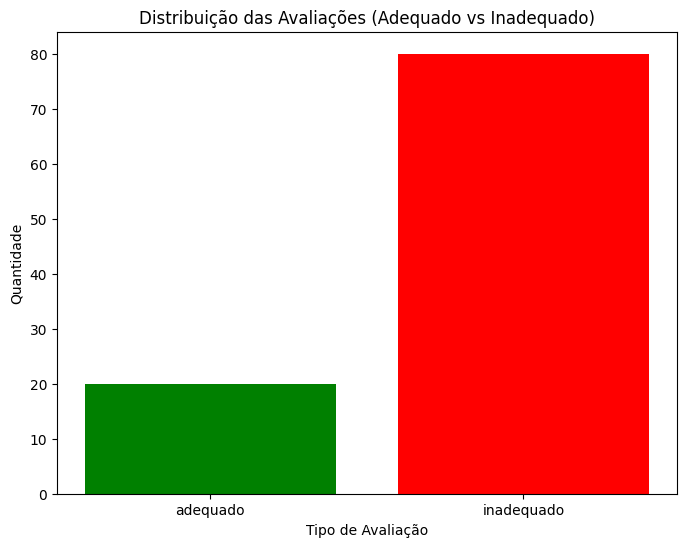

In [18]:
import json
import matplotlib.pyplot as plt

# Carregar os resultados de avaliação
with open(r'/home/lisamenezes/RAG-benchmark/results/chromadb_results.json', 'r', encoding='utf-8') as f:
    evaluation_results = json.load(f)

# Contar as avaliações adequadas e inadequadas
evaluation_counts = {"adequado": 0, "inadequado": 0}
for result in evaluation_results:
    evaluation = result["evaluation"].lower()  # Garantir consistência de casos
    if evaluation in evaluation_counts:
        evaluation_counts[evaluation] += 1

# Calcular a porcentagem de adequados
total = sum(evaluation_counts.values())
percentage_adequados = (evaluation_counts["adequado"] / total) * 100 if total > 0 else 0

# Criar o gráfico
labels = list(evaluation_counts.keys())
sizes = list(evaluation_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=['green', 'red'])
plt.title("Distribuição das Avaliações (Adequado vs Inadequado)")
plt.xlabel("Tipo de Avaliação")
plt.ylabel("Quantidade")
plt.xticks(labels)

# Mostrar a porcentagem de adequados no console
print(f"Porcentagem de avaliações adequadas: {percentage_adequados:.2f}%")

plt.show()